<a href="https://colab.research.google.com/github/sreshu/MoodMuse/blob/main/BHACK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 38.7 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/REWTAO/Facial-emotion-recognition-using-mediapipe

Cloning into 'Facial-emotion-recognition-using-mediapipe'...
remote: Enumerating objects: 181, done.
remote: Total 181 (delta 0), reused 0 (delta 0), pack-reused 181
Receiving objects: 100% (181/181), 1.15 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [ ]:
import cv2
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils


In [ ]:
import json
import spotipy
import webbrowser
# import pyautogui
import time

In [ ]:
import csv
import copy
import itertools

import cv2 as cv
import numpy as np
import mediapipe as mp
# from model import KeyPointClassifier

In [ ]:
import sys,os

In [ ]:
import numpy as np
import tensorflow as tf


class KeyPointClassifier(object):
    def __init__(
        self,
        model_path='/content/Facial-emotion-recognition-using-mediapipe/model/keypoint_classifier/keypoint_classifier.tflite',
        num_threads=1,
    ):
        self.interpreter = tf.lite.Interpreter(model_path=model_path,
                                               num_threads=num_threads)

        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.last_index = 2

    def __call__(
        self,
        landmark_list,
    ):
        input_details_tensor_index = self.input_details[0]['index']
        self.interpreter.set_tensor(
            input_details_tensor_index,
            np.array([landmark_list], dtype=np.float32))
        self.interpreter.invoke()

        output_details_tensor_index = self.output_details[0]['index']

        result = self.interpreter.get_tensor(output_details_tensor_index)
        if np.max(result) >= 0.85:
            result_index = np.argmax(np.squeeze(result))
            self.last_index =  result_index
            return result_index
        else:
            return self

In [ ]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point


In [ ]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list


In [ ]:
def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        # Outer rectangle
        cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 0, 0), 1)

    return image

In [ ]:
def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv.boundingRect(landmark_array)

    return [x, y, x + w, y + h]

In [ ]:
def draw_info_text(image, brect, facial_text):
    cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[1] - 22),
                 (0, 0, 0), -1)

    if facial_text != "":
        info_text = 'Emotion :' + facial_text
    cv.putText(image, info_text, (brect[0] + 5, brect[1] - 4),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv.LINE_AA)

    return image

In [ ]:
cap_device = 0
cap_width = 1920
cap_height = 1080

use_brect = True

# Camera preparation
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

# Model load
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) 

In [ ]:
keypoint_classifier = KeyPointClassifier()

In [ ]:
# Read labels
with open('/content/Facial-emotion-recognition-using-mediapipe/model/keypoint_classifier/keypoint_classifier_label.csv',
            encoding='utf-8-sig') as f:
    keypoint_classifier_labels = csv.reader(f)
    keypoint_classifier_labels = [
        row[0] for row in keypoint_classifier_labels
    ]


In [ ]:
# from IPython.display import Audio
# wn = Audio('path_to_wav_file', autoplay=True)
# display(wn)

In [ ]:
from IPython.display import YouTubeVideo
from IPython.display import Image, Audio


In [ ]:
def process_img():

  mode = 0

  # while True:

      # Process Key (ESC: end)
      # key = cv.waitKey(10)
      # if key == 27:  # ES
          # breasjdgfjhadsghfuehfk

      # Camera captkhfksfhre
      # ret, image = cap.read()
      # if not ret:
      #     break
  image = cv.imread('/content/photo.jpg')
  image = cv.flip(image, 1)  # Mirror display
  debug_image = copy.deepcopy(image)

      # Detection implementation
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

  image.flags.writeable = False
  results = face_mesh.process(image)
  image.flags.writeable = True

  if results.multi_face_landmarks is not None:
      for face_landmarks in results.multi_face_landmarks:
          # Bounding box calculation
          brect = calc_bounding_rect(debug_image, face_landmarks)

          # Landmark calculation
          landmark_list = calc_landmark_list(debug_image, face_landmarks)

          # Conversion to relative coordinates / normalized coordinates
          pre_processed_landmark_list = pre_process_landmark(
              landmark_list)

          #emotion classification
          facial_emotion_id = keypoint_classifier(pre_processed_landmark_list)
          # Drawing part
          print("The emotion id is --> ", facial_emotion_id)
          
          debug_image = draw_bounding_rect(use_brect, debug_image, brect)
          debug_image = draw_info_text(
                  debug_image,
                  brect,
                  keypoint_classifier_labels[facial_emotion_id])
          
          #1:happy, 2: neutral, 4:happily surprised
          if facial_emotion_id == 1: 
            print("Time to play more happy songs")
          elif facial_emotion_id == 2:
            print("Time to cheer you up with happy songs")
            # IPython.display.Audio('/cheering.wav') # This is required on Google Colab due to compatibility issues

          elif facial_emotion_id == 4:
            print("Let's play a less surprising song")
          else:
            print("just chill")
            

  # Screen rvflectioe
  cv.imwrite('/content/photo_out.jpg', debug_image)
  print("Image is processed ")
# cap.release()
  # cv.destroyAllWindows()

In [ ]:
process_img()

The emotion id is -->  2
Time to cheer you up with happy songs
Image is processed heyy


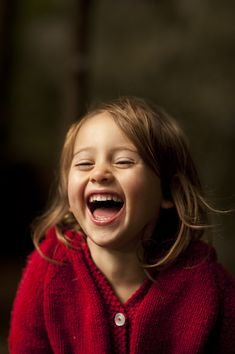

In [ ]:
Image('smile.jpg')

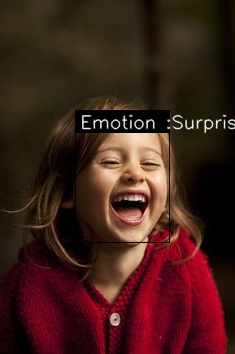

In [ ]:
Image('smiley.jpg')

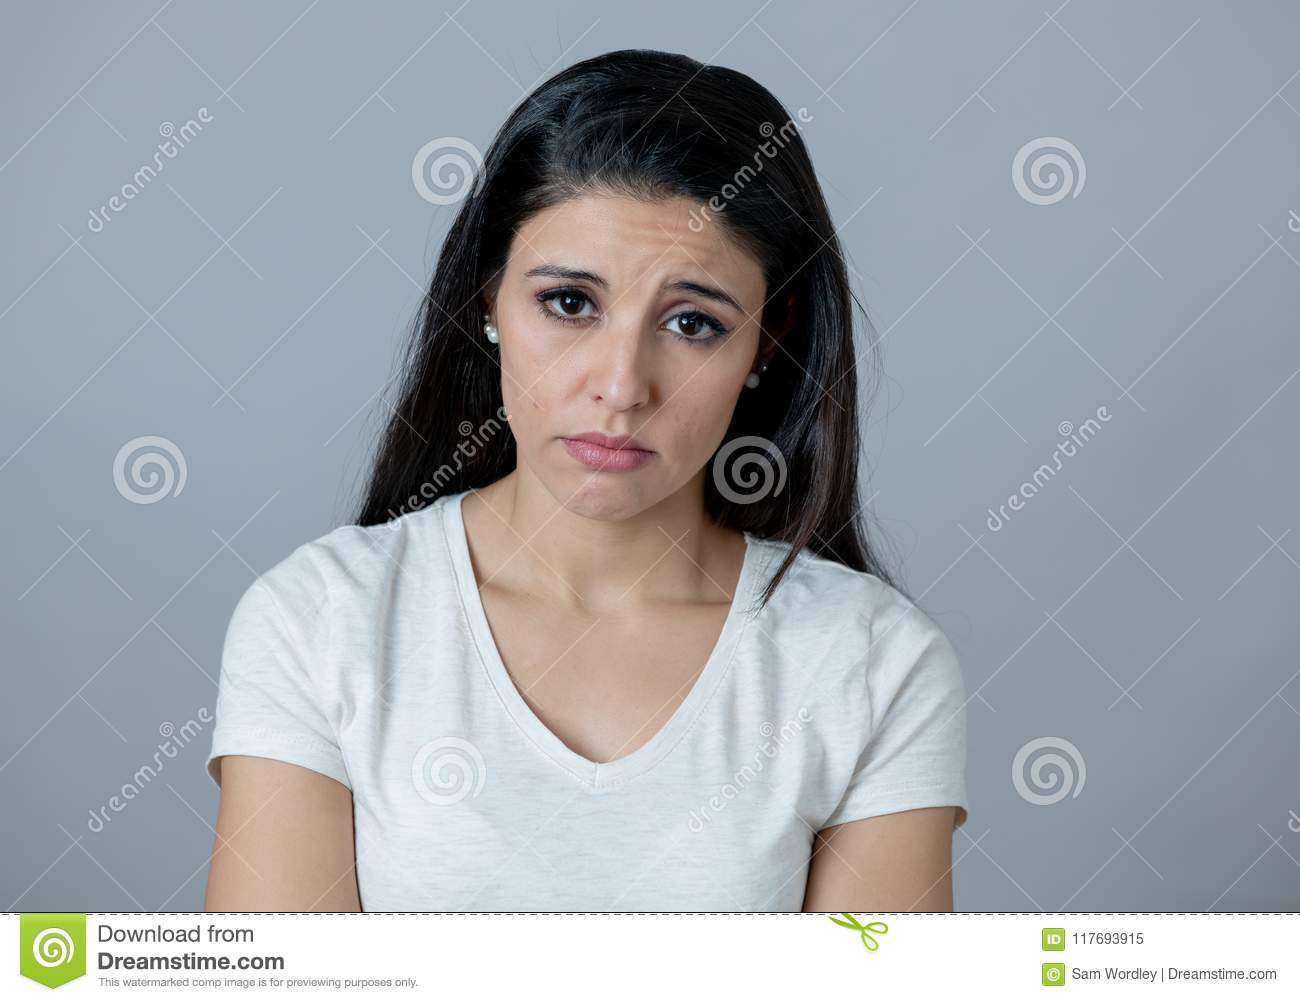

In [ ]:
Image('neutral.jpg')

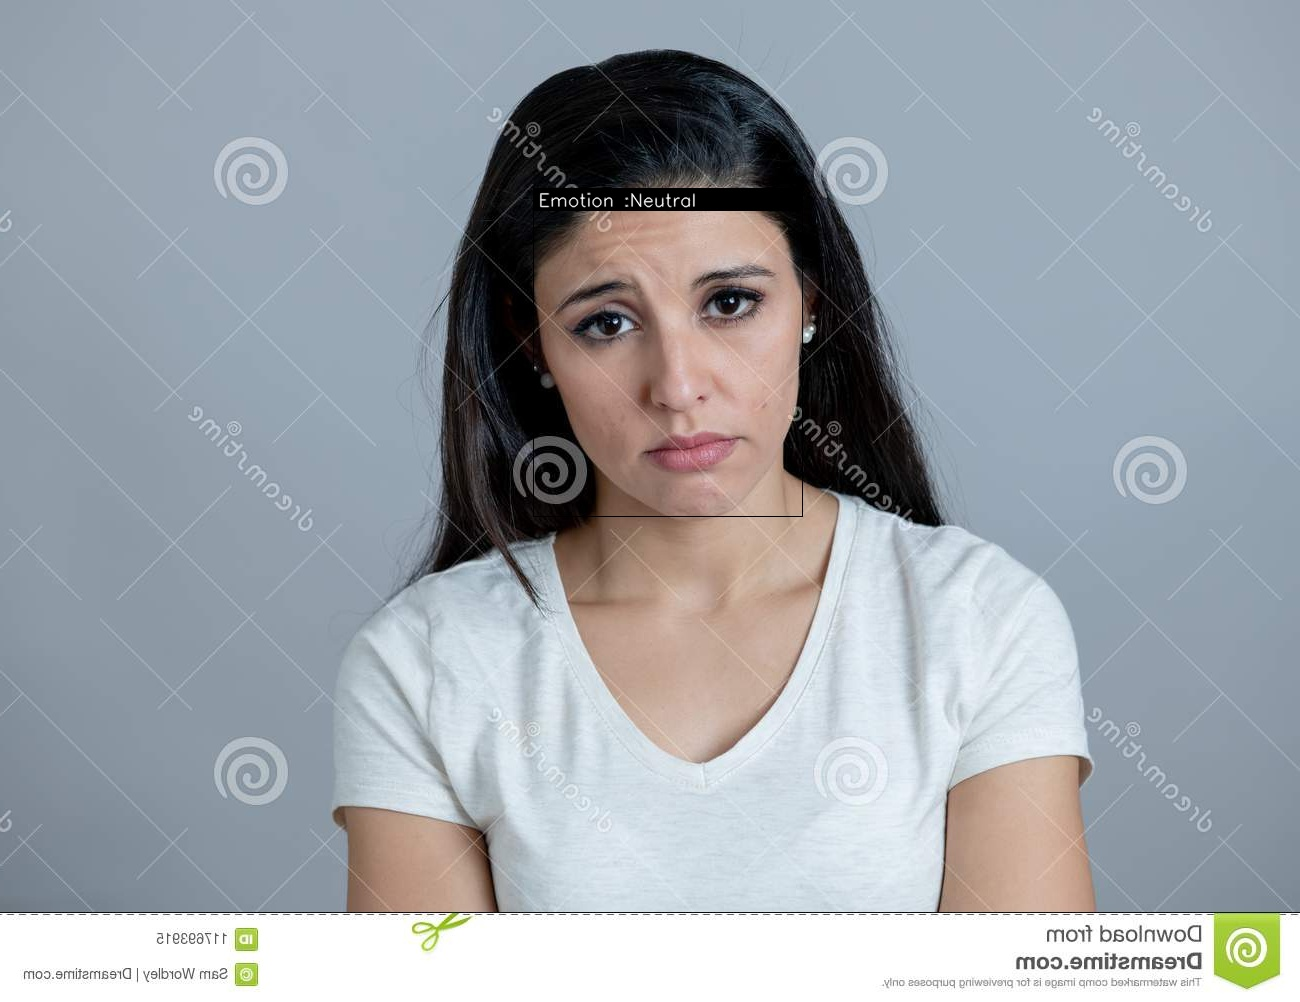

In [ ]:
Image('neutral_out.jpg')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


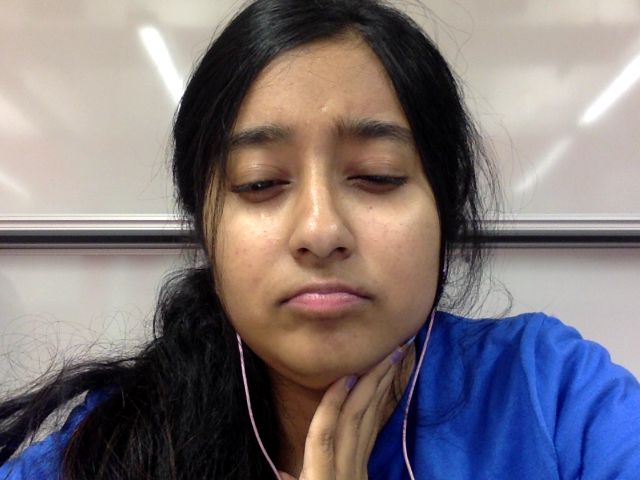

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
process_img()

The emotion id is -->  2
Time to cheer you up with happy songs
Image is processed heyy


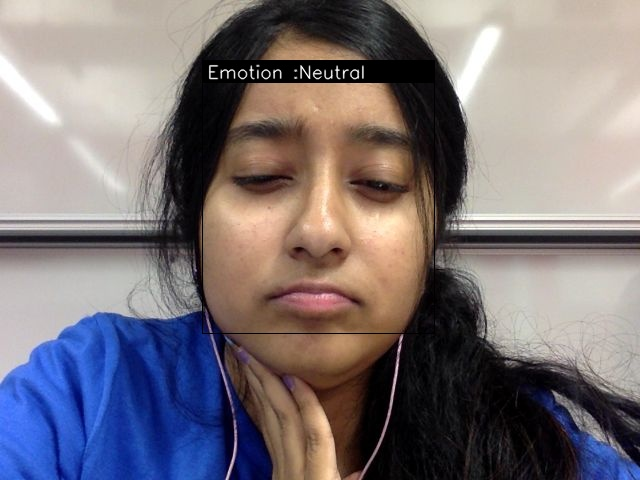

In [ ]:
Image('/content/photo_out.jpg')

Audio Analysis using librosa *library*

In [ ]:
import librosa
import numpy as np
import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
def extract_features(audio_file):
    X, sample_rate = librosa.load(audio_file, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)

    return mfccs



In [ ]:
audio_file = "/cheering.wav"

x , sr = librosa.load(audio_file)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(99540,) 22050


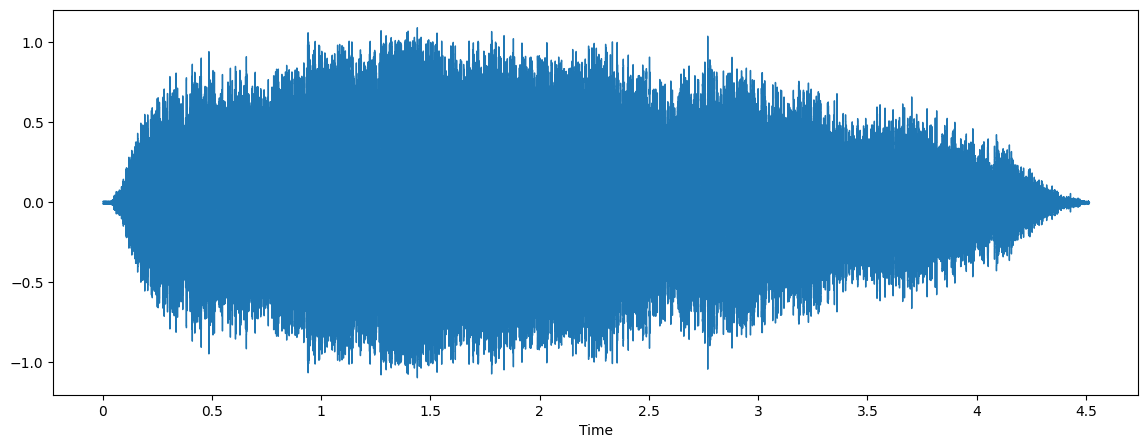

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

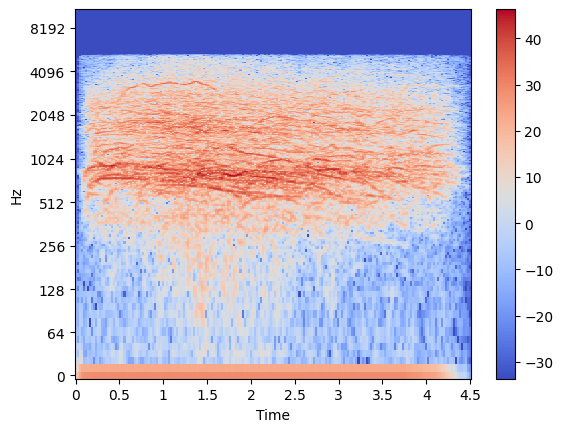

In [ ]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()